# Creating an End-to-end BlazeFace Onnx model

In [3]:
!pip install onnxruntime --quiet
! pip install tf2onnx --quiet
!pip install onnx --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 44.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 451.2/451.2 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 73.8 MB/s eta 0:00:00


In [4]:
import numpy as np
import torch
import cv2

from onnxruntime import InferenceSession
import onnx

import tf2onnx
import tensorflow as tf

In [5]:
print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("cuDNN version:", torch.backends.cudnn.version())

PyTorch version: 2.0.1+cu118
CUDA version: 11.8
cuDNN version: 8700


## First get the Raw Tflite BlazeFace Model from Google and convert it to Onnx

In [6]:
## First Grab the tflite model from google
!wget https://storage.googleapis.com/mediapipe-models/face_detector/blaze_face_short_range/float16/latest/blaze_face_short_range.tflite

--2023-06-30 17:42:31--  https://storage.googleapis.com/mediapipe-models/face_detector/blaze_face_short_range/float16/latest/blaze_face_short_range.tflite
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.11.128, 142.250.97.128, 173.194.215.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.11.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 229746 (224K) [application/octet-stream]
Saving to: ‘blaze_face_short_range.tflite’

blaze_face_short_ra 100%[===================>] 224.36K  --.-KB/s    in 0.002s  

2023-06-30 17:42:31 (108 MB/s) - ‘blaze_face_short_range.tflite’ saved [229746/229746]



In [7]:
 ## Double check the input and output information
interpreter = tf.lite.Interpreter(model_path = '/content/blaze_face_short_range.tflite')
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

output_details, input_details

([{'name': 'regressors',
   'index': 175,
   'shape': array([  1, 896,  16], dtype=int32),
   'shape_signature': array([  1, 896,  16], dtype=int32),
   'dtype': numpy.float32,
   'quantization': (0.0, 0),
   'quantization_parameters': {'scales': array([], dtype=float32),
    'zero_points': array([], dtype=int32),
    'quantized_dimension': 0},
   'sparsity_parameters': {}},
  {'name': 'classificators',
   'index': 174,
   'shape': array([  1, 896,   1], dtype=int32),
   'shape_signature': array([  1, 896,   1], dtype=int32),
   'dtype': numpy.float32,
   'quantization': (0.0, 0),
   'quantization_parameters': {'scales': array([], dtype=float32),
    'zero_points': array([], dtype=int32),
    'quantized_dimension': 0},
   'sparsity_parameters': {}}],
 [{'name': 'input',
   'index': 0,
   'shape': array([  1, 128, 128,   3], dtype=int32),
   'shape_signature': array([  1, 128, 128,   3], dtype=int32),
   'dtype': numpy.float32,
   'quantization': (0.0, 0),
   'quantization_parameters': 

In [8]:
# Convert the model into onnx, specify opset for your use case
!python -m tf2onnx.convert --tflite /content/blaze_face_short_range.tflite --output /content/mpipe_bface_ops16.onnx --opset 16

/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2023-06-30 17:42:40,096 - INFO - Using tensorflow=2.12.0, onnx=1.14.0, tf2onnx=1.14.0/8f8d49
2023-06-30 17:42:40,096 - INFO - Using opset <onnx, 16>
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
2023-06-30 17:42:40,113 - WARNING - Error loading model into tflite interpreter: Interpreter._get_tensor_details() missing 1 required positional argument: 'subgraph_index'
2023-06-30 17:42:40,636 - INFO - Optimizing ONNX model
2023-06-30 17:42:42,175 - INFO - After optimization: Cast -78 (78->0), Const -41 (116->75), Identity -2 (2->0), Reshape -16 (20->4), Transpose -149 (154->5)
2023-06-30 17:42:42,224 - INFO - 
2023-06-30 17:42:42,225 - INFO - Successfully converted TensorFlow model /content/blaze_face_short_range.tflite to ONNX
2023-06-30 17:42:

## Now add the Onnx Prefix

In [9]:
## Displacy code taken from https://github.com/hollance/BlazeFace-PyTorch.git

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_detections(img, detections, with_keypoints=True):
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.grid(False)
    ax.imshow(img)

    if isinstance(detections, torch.Tensor):
        detections = detections.cpu().numpy()

    if detections.ndim == 1:
        detections = np.expand_dims(detections, axis=0)

    print("Found %d faces" % detections.shape[0])

    for i in range(detections.shape[0]):
        ymin = detections[i, 0] * img.shape[0]
        xmin = detections[i, 1] * img.shape[1]
        ymax = detections[i, 2] * img.shape[0]
        xmax = detections[i, 3] * img.shape[1]

        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 linewidth=1, edgecolor="r", facecolor="none",
                                )
        ax.add_patch(rect)

        if with_keypoints:
            for k in range(6):
                kp_x = detections[i, 4 + k*2    ] * img.shape[1]
                kp_y = detections[i, 4 + k*2 + 1] * img.shape[0]
                circle = patches.Circle((kp_x, kp_y), radius=0.5, linewidth=1,
                                        edgecolor="lightskyblue", facecolor="none"
                                        )
                ax.add_patch(circle)

    plt.show()

# Now using onnx

### helper functions

In [10]:
anchors = torch.tensor(np.load('/content/anchors.npy'), dtype=torch.float32)
anchors.shape

torch.Size([896, 4])

In [11]:
anchors_scale = torch.vstack(
    (anchors[..., 2],
     anchors[..., 3],
     anchors[..., 2],
     anchors[..., 3],
     anchors[..., 2],
     anchors[..., 3],
     anchors[..., 2],
     anchors[..., 3],
     anchors[..., 2],
     anchors[..., 3],
     anchors[..., 2],
     anchors[..., 3],
     anchors[..., 2],
     anchors[..., 3],
     anchors[..., 2],
     anchors[..., 3])).T
anchors_scale = anchors_scale.unsqueeze(0)

In [12]:
anchors_add = torch.vstack(
    (anchors[..., 0],
     anchors[..., 1],
     torch.zeros_like( anchors[..., 2]),
     torch.zeros_like( anchors[..., 3]),
     anchors[..., 0],
     anchors[..., 1],
     anchors[..., 0],
     anchors[..., 1],
     anchors[..., 0],
     anchors[..., 1],
     anchors[..., 0],
     anchors[..., 1],
     anchors[..., 0],
     anchors[..., 1],
     anchors[..., 0],
     anchors[..., 1],)).T

In [13]:
nub = np.array(
    [[0, 1, 0, -0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     [1, 0, -0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      [0, 1, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]).T
nub.shape

(16, 16)

In [14]:
t_nub = torch.tensor(nub, dtype=torch.float32)

In [15]:
from onnx import TensorProto, numpy_helper
from onnx.helper import (
    make_model, make_node, make_graph,
    make_tensor_value_info)
from onnx.checker import check_model

In [16]:
## Inputs
rawBoxes = make_tensor_value_info('rawBoxes', TensorProto.FLOAT, [1, 896, 16])
rawScores = make_tensor_value_info('rawScores', TensorProto.FLOAT, [1, 896, 1])
conf_threshold = make_tensor_value_info('conf_threshold', TensorProto.FLOAT, [1])
max_output_boxes = make_tensor_value_info('max_detections', TensorProto.INT64, [1])
iou_threshold = make_tensor_value_info('iou_threshold', TensorProto.FLOAT, [1])

## Outputs
# finalBoxes = make_tensor_value_info('finalBoxes', TensorProto.FLOAT, [1, 896, 16])
# finalBoxMask = make_tensor_value_info('finalScores', TensorProto.FLOAT, [1, 896, 1])
# selected_indices = make_tensor_value_info('selected_indices', TensorProto.INT64, [896, 1])
selectedBoxes = make_tensor_value_info('selectedBoxes', TensorProto.FLOAT, [1, 896, 16])
# selectedScores = make_tensor_value_info('selectedScores', TensorProto.FLOAT, [1, 896, 1])


## Constants
n1_indices = numpy_helper.from_array(np.array([0, 1, 2, 3], dtype=np.int0), name='n1_indices')
n6_min = numpy_helper.from_array(np.array([-100], dtype=np.float32), name='n6_min')
n6_max = numpy_helper.from_array(np.array([100], dtype=np.float32), name='n6_max')

# conf_threshold = numpy_helper.from_array(np.array([.8], dtype=np.float32), name='conf_threshold')
# max_output_boxes = numpy_helper.from_array(np.array([10], dtype=np.int64), name='max_detections')
# iou_threshold = numpy_helper.from_array(np.array([.4], dtype=np.float32), name='iou_threshold')

scale = numpy_helper.from_array(np.array([128], dtype=np.float32), name='scale')
anchors_scale_o = numpy_helper.from_array(anchors_scale.numpy(), name='anchors_scale')
anchors_add_o = numpy_helper.from_array(anchors_add.numpy(), name='anchors_add')
t_nub_o = numpy_helper.from_array(t_nub.numpy(), name='t_nub')

n11_indices = numpy_helper.from_array(np.array([2], dtype=np.int0), name='n11_indices')


#### Raw Boxes -> final Boxes
# node1 = make_node('Gather', ['rawBoxes', 'n1_indices'], ['rawBoxesSliced'], axis = 2)

node2 = make_node('Div', ['rawBoxes', 'scale'], ['n2_out'])
node3 = make_node('Mul', ['n2_out', 'anchors_scale'], ['n3_out'])
node4 = make_node('Add', ['n3_out', 'anchors_add'], ['n4_out'])
node5 = make_node('MatMul', ['n4_out', 't_nub'], ['finalBoxes'])

#### Raw pred scores -> real pred scores
node6 = make_node('Clip', ['rawScores', 'n6_min', 'n6_max'], ['n6_out'])
node7 = make_node('Sigmoid', ['n6_out'], ['finalScores'])

#### Generate Mask of Scores over Threshold
node8 = make_node('Gather', ['finalBoxes', 'n1_indices'], ['finalBoxesCoords'], axis = 2)
node9 = make_node('Transpose', ['finalScores'], ['finalScores_T'], perm = [0, 2, 1])
node10 = make_node('NonMaxSuppression', ['finalBoxesCoords', 'finalScores_T', 'max_detections', 'iou_threshold', 'conf_threshold'], ['raw_selected_indices'], center_point_box = 1)

node11 = make_node('Gather', ['raw_selected_indices', 'n11_indices'], ['selected_indices_'], axis = 1)
node12 = make_node('Squeeze', ['selected_indices_'], ['selected_indices'])
node13 = make_node('Gather', ['finalBoxes', 'selected_indices'], ['selectedBoxes'], axis=1)


graph = make_graph(
    [ node2, node3, node4, node5, node6, node7, node8, node9, node10, node11, node12, node13 ],
    "boxExtract",
     [rawBoxes, rawScores, conf_threshold, max_output_boxes, iou_threshold],
     [selectedBoxes],
     [scale, anchors_scale_o, anchors_add_o, t_nub_o, n1_indices, n6_min, n6_max, n11_indices])

In [17]:
onnx_model = make_model(graph)
check_model(onnx_model)

# print(onnx_model)
onnx_model
onnx.save_model(onnx_model, '/content/box_model.onnx');

In [18]:
box_sess = InferenceSession('/content/box_model.onnx')

In [19]:
def decode_onnx(raw_boxes, raw_score):
  out = box_sess.run(None, {'rawBoxes': raw_boxes, 'rawScores': raw_score, 'conf_threshold': [.75], 'max_detections': [100], 'iou_threshold': [.3]})
  return out

## BlazeFace onnx model inference

In [20]:

model_path = '/content/mpipe_bface_ops16.onnx'

sess = InferenceSession(model_path)

for i in sess.get_inputs():
  print("Expected input -", i.name, "- shape: ", i.shape)

for o in sess.get_outputs():
  print("Exptected output -", o.name, "-shape: ", o.shape)

Expected input - input - shape:  [1, 128, 128, 3]
Exptected output - regressors -shape:  [1, 896, 16]
Exptected output - classificators -shape:  [1, 896, 1]


In [21]:
img = cv2.imread("person.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print("Raw img shape:", img.shape)
pimg = cv2.resize(img, (128, 128))
pimg = pimg /127.5 - 1.0
pimg = np.expand_dims(pimg, axis=0).astype(np.float32)
print("Processed img shape:", pimg.shape)

Raw img shape: (720, 1280, 3)
Processed img shape: (1, 128, 128, 3)


In [22]:
out  = sess.run(None, {'input': pimg})
out[0].shape, out[1].shape

((1, 896, 16), (1, 896, 1))

In [23]:
onnxout = decode_onnx(out[0], out[1])
onnxout[0].shape

(1, 16)

Found 1 faces


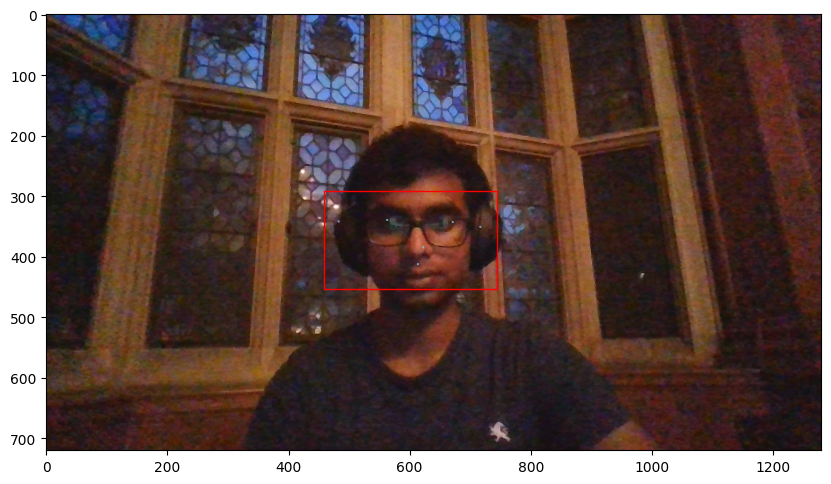

In [24]:
plot_detections(img, onnxout[0])

## Combine BlazeFace Onnx with Box processor
## (Onnx surgery)

In [25]:
from onnx import load, helper

In [26]:
mpipe_bface = onnx.load('/content/mpipe_bface_ops16.onnx')
onnx_model.opset_import

[version: 19
]

In [27]:
onnx_model_ops16 = onnx.version_converter.convert_version(onnx_model, 16)


In [28]:
mpipe_bface.ir_version, onnx_model_ops16.ir_version,

(8, 9)

In [29]:
mpipe_bface.opset_import,

([domain: ""
 version: 16
 , domain: "ai.onnx.ml"
 version: 2
 ],)

In [30]:
 onnx_model_ops16.opset_import

[domain: ""
version: 16
]

In [31]:
onnx_model_ops16.ir_version = 8


In [32]:
mpipe_bface_boxes = onnx.compose.merge_models(m1 = mpipe_bface, m2 = onnx_model_ops16, io_map = [('regressors', 'rawBoxes'), ('classificators', 'rawScores')], )

In [33]:
onnx.save(mpipe_bface_boxes, '/content/mpipe_bface_boxes_ops16.onnx')

## Run inference with box-out model

In [34]:
processed_boxsess = InferenceSession('/content/mpipe_bface_boxes_ops16.onnx')

In [35]:
img = cv2.imread("person.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print("Raw img shape:", img.shape)
pimg = cv2.resize(img, (128, 128))
pimg = pimg /127.5 - 1.0
pimg = np.expand_dims(pimg, axis=0).astype(np.float32)
print("Processed img shape:", pimg.shape)

Raw img shape: (720, 1280, 3)
Processed img shape: (1, 128, 128, 3)


In [36]:
out3 = processed_boxsess.run(None, {'input':pimg, 'conf_threshold': [.75], 'max_detections': [100], 'iou_threshold': [.3]})
out3[0].shape

(1, 16)

Found 1 faces


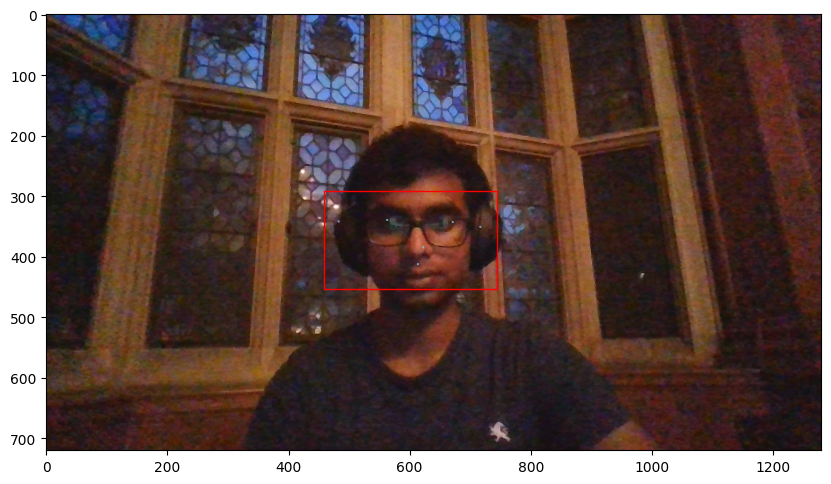

In [37]:
plot_detections(img, out3[0])

## Bonus, because my use case required the model to take in CHW images

In [38]:
! pip install tf2onnx --quiet
import onnx
import tf2onnx
from tensorflow.keras import layers
import tensorflow as tf

In [39]:
# takes 1, c, h, w and outs 1, h, w, c
transposer = tf.keras.Sequential([
    layers.Permute((2, 3, 1))
])


In [40]:
input_signature = [tf.TensorSpec([1, 3, 128, 128], tf.float32, name='image')]

In [41]:
transp_model, _ = tf2onnx.convert.from_keras(transposer, input_signature, opset=16)
onnx.save(transp_model, "/content/transp.onnx")

In [42]:
transp_model ## Double check the transp_model's output name

ir_version: 8
producer_name: "tf2onnx"
producer_version: "1.14.0 8f8d49"
graph {
  node {
    input: "image"
    output: "permute"
    name: "sequential/permute/transpose"
    op_type: "Transpose"
    attribute {
      name: "perm"
      ints: 0
      ints: 2
      ints: 3
      ints: 1
      type: INTS
    }
  }
  name: "tf2onnx"
  doc_string: "converted from sequential"
  input {
    name: "image"
    type {
      tensor_type {
        elem_type: 1
        shape {
          dim {
            dim_value: 1
          }
          dim {
            dim_value: 3
          }
          dim {
            dim_value: 128
          }
          dim {
            dim_value: 128
          }
        }
      }
    }
  }
  output {
    name: "permute"
    type {
      tensor_type {
        elem_type: 1
        shape {
          dim {
            dim_value: 1
          }
          dim {
            dim_value: 128
          }
          dim {
            dim_value: 128
          }
          dim {
       

In [43]:
comb_model = onnx.compose.merge_models(m1 = transp_model, m2 = mpipe_bface_boxes, io_map = [('permute', 'input')])

In [44]:
onnx.save(comb_model, '/content/T_mpipe_bface_boxes_ops16.onnx')